# Correlation, Causality and multiCollinearity

For a good explanation, see: 

https://www.otexts.org/fpp/5/7

Let's stop and check that out.

### Back to our BART data

In [1]:
%matplotlib inline

import pandas as pd
import seaborn as sns
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
# This data has
bart = pd.read_csv('data/BARTEstimationFile.csv', parse_dates=['MONTH'], index_col='MONTH')
bart.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 177 entries, 2001-01-01 to 2015-09-01
Data columns (total 22 columns):
RIDERS                     177 non-null float64
STATIONS                   177 non-null int64
CASH_FARE_2010USD_BART     175 non-null float64
AVG_FARE_2010USD_BART      175 non-null float64
HH                         168 non-null float64
HH_0VEH                    168 non-null float64
POP                        168 non-null float64
WORKERS                    168 non-null float64
MEDIAN_HHINC_2010USD       168 non-null float64
SERVMILES_E_BART           177 non-null float64
TOTEMP                     171 non-null float64
RETAIL_EMP                 171 non-null float64
EDHEALTH_EMP               171 non-null float64
LEISURE_EMP                171 non-null float64
OTHER_EMP                  171 non-null float64
FUEL_PRICE_2010USD         171 non-null float64
FUEL_COST_2010USD          171 non-null float64
TOLL_BB_PK_2010USD         171 non-null float64
TOLL_BB_OP_201

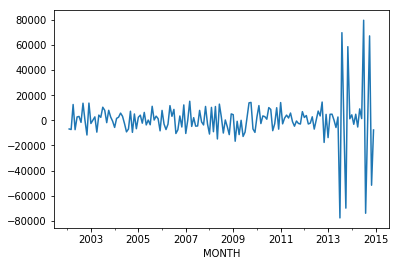

In [3]:
# drop missing values
bart = bart.dropna()

# calculate second difference
diff = bart - bart.shift(12)
diff2 = diff - diff.shift(1)
diff2['RIDERS'].plot()

In [4]:
# start from the variables we think are important

mod = smf.ols(formula='RIDERS ~ \
              SERVMILES_E_BART \
              + TOTEMP \
              + WORKERS \
              + CASH_FARE_2010USD_BART \
              + FUEL_COST_2010USD \
              + BART_STRIKE \
              - 1', 
              data=diff2[13:])
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                 RIDERS   R-squared:                       0.837
Model:                            OLS   Adj. R-squared:                  0.831
Method:                 Least Squares   F-statistic:                     127.8
Date:                Tue, 17 Apr 2018   Prob (F-statistic):           3.59e-56
Time:                        12:44:08   Log-Likelihood:                -1591.1
No. Observations:                 155   AIC:                             3194.
Df Residuals:                     149   BIC:                             3212.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
SERVMILES_E_BART           0

It seems like we might have multicollinearity issues.  There are some statistical tests for this, or we can examine the covariance matrix.  For now, let's see if we can figure out what's going on a bit more intuitively.  

In [ ]:
# a simple thing we can do is look at the data

fields = ['RIDERS', 'SERVMILES_E_BART', 'TOTEMP', 'WORKERS', 'CASH_FARE_2010USD_BART', 'FUEL_COST_2010USD', 'BART_STRIKE']

sns.pairplot(diff2[fields][13:])


In [ ]:
fields = ['RIDERS', 'SERVMILES_E_BART', 'TOTEMP', 'WORKERS', 'CASH_FARE_2010USD_BART', 'FUEL_COST_2010USD', 'BART_STRIKE']

bart[fields][13:].plot(subplots=True)

In [ ]:
# workers and totemp seem to move together.  What if we drop one or the other? 

mod = smf.ols(formula='RIDERS ~ \
              SERVMILES_E_BART \
              + TOTEMP \
              + CASH_FARE_2010USD_BART \
              + FUEL_COST_2010USD \
              + BART_STRIKE \
              - 1', 
              data=diff2[13:])
res = mod.fit()
print(res.summary())

In [ ]:
# workers and totemp seem to move together.  What if we drop one or the other? 

mod = smf.ols(formula='RIDERS ~ \
              SERVMILES_E_BART \
              + WORKERS \
              + CASH_FARE_2010USD_BART \
              + FUEL_COST_2010USD \
              + BART_STRIKE \
              - 1', 
              data=diff2[13:])
res = mod.fit()
print(res.summary())

Notice how the coefficients change.  One thing we can try is to specify a different variable that gets at a similar effect, but might be less collinear. 

In [ ]:
# what if we substitute population for workers?

mod = smf.ols(formula='RIDERS ~ \
              SERVMILES_E_BART \
              + TOTEMP \
              + POP \
              + CASH_FARE_2010USD_BART \
              + FUEL_COST_2010USD \
              + BART_STRIKE \
              - 1', 
              data=diff2[13:])
res = mod.fit()
print(res.summary())

In [ ]:
# what if now drop the insignificant terms? 

mod = smf.ols(formula='RIDERS ~ \
              + TOTEMP \
              + BART_STRIKE \
              - 1', 
              data=diff2[13:])
res = mod.fit()
print(res.summary())

The R-squared is almost as good, but we can't predict what will happen if we change one of the other variables.  Sometimes we want to leave in an insignificant variable for theoretical or policy-sensitive reasons. 

In [ ]:
# And what if we drop the BART_STRIKE variable

mod = smf.ols(formula='RIDERS ~ \
              + TOTEMP \
              - 1', 
              data=diff2[13:])
res = mod.fit()
print(res.summary())

Wow, that's a lot different!  In this case, we've run into 'ommitted variable bias', where our coefficients are biased (and our model is lousy) because we're missing something important.  So what do we do?  

### Recommendations

Our friends at Northwestern (my alma mater!) have some good recommendations for how to 
proceed with these issues. 

Model Specification: Choosing the Right Variables for the Right Hand Side

https://www.kellogg.northwestern.edu/faculty/dranove/htm/dranove/coursepages/Mgmt%20469/choosing%20variables.pdf

They suggest: 

1) Always begin with a “core” set of predictors that have theoretical relevance, as well as any predictors whose effects you are specifically interested in. You may estimate a “quick and dirty” OLS model at this time. 

2) Finalize model specification issues (e.g., log vs. linear – to be discussed in a later note) 

3) Add additional predictors that you think might be relevant. You can add them one at a time or one “category” at a time (see next section). Check for the robustness of your initial findings. 

4) When adding predictors, you should keep all the original predictors in the model, even if they were not significant. Remember, omitted variable bias can cause significant predictors to appear to be insignificant. By adding more variables, your key predictors may become significant. 

5) At this point, you should know your robust findings. That is the main goal of your research. 

6) If you insist on producing a “final model”, then you should remove those additional predictors that were not remotely significant.


7) You can also remove core predictors if they remain insignificant and you need degrees of freedom. If you are not taxed for degrees of freedom, you may want to keep your core variables, if only to paint the entire picture for your audience.

### Homework

1. Read the model specification document referenced above. \
2. Given what you have learned today, develop a new BART ridership model.  Make that model an ARMA model with independent regressors.  Specify the regressors in a logical way, and make sure your data are stationary before you begin.  Justify your preferred model. 